# Text classification with Transformer

Implement a Transformer block as a Keras layer and use it for text classification.

## Setup

In [112]:
import keras
import pandas as pd
from keras import ops
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Implement a Transformer block as a layer

In [113]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

## Implement embedding layer

Two  embedding layers, one for tokens, one for token index (positions).

In [114]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

### Cargar el dataset

In [115]:
df = pd.read_csv("dataset/updated_language_detection.csv")
df.describe()

,Text,Language
count,21821,21821
unique,21821,22
top,aprilie sonda spațială messenger a nasa și-a ...,Japanese
freq,1,1000


In [123]:
df = df[df['Language'] != 'Chinese']
df.describe()

,Text,Language
count,20821,20821
unique,20821,21
top,aprilie sonda spațială messenger a nasa și-a ...,Thai
freq,1,1000


### Preprocesar el Texto

- Tokenización: Convertir el texto en tokens (palabras).
- Padding: Asegurarse de que todas las secuencias de texto tengan la misma longitud.

In [135]:
# Unir todos los textos en una lista
texts = df['Text'].values

# Inicializar el Tokenizer para convertir texto en índices
maxlen=300
vocab_size = 200000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)

# Convertir los textos a secuencias de índices
X = tokenizer.texts_to_sequences(texts)

# Padding para asegurar que todas las secuencias tengan la misma longitud
X = pad_sequences(X, maxlen=maxlen)
X[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

### Codificar las Etiquetas

Codificamos las etiquetas (idiomas) en valores numéricos.

In [136]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Language'])
y[:5]

array([ 3, 16, 18, 17,  1])

### Dividir el dataset en conjuntos de entrenamiento y prueba

Se utiliza stratify para mantener la proporción de clases en los conjuntos de entrenamiento y prueba.

Train: 70%

Validation: 10%

Test: 20%

In [137]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['Language'])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

print("Entrenamiento:", X_train.shape, y_train.shape)
print("Validación:", X_val.shape, y_val.shape)
print("Prueba:", X_test.shape, y_test.shape)

Entrenamiento: (14574, 300) (14574,)
Validación: (2082, 300) (2082,)
Prueba: (4165, 300) (4165,)


## Create classifier model using transformer layer

Transformer layer outputs one vector for each time step of our input sequence.
Here, we take the mean across all time steps and
use a feed forward network on top of it to classify text.

In [138]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
#x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
#x = layers.Dropout(0.1)(x)
outputs = layers.Dense(len(label_encoder.classes_), activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_14 │ (None, 300, 32)        │     6,409,600 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_14            │ (None, 300, 32)        │        10,656 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_12     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 21)             │           441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,421,357 (24.50 MB)

 Trainable params: 6,421,357 (24.50 MB)

 Non-trainable params: 0 (0.00 B)

## Train and Evaluate

In [139]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val)
)

Epoch 1/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 121s 252ms/step - accuracy: 0.2490 - loss: 2.4906 - val_accuracy: 0.9630 - val_loss: 0.1784
Epoch 2/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 122s 268ms/step - accuracy: 0.9773 - loss: 0.1151 - val_accuracy: 0.9669 - val_loss: 0.1310
Epoch 3/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 99s 216ms/step - accuracy: 0.9903 - loss: 0.0402 - val_accuracy: 0.9750 - val_loss: 0.0947
Epoch 4/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 152s 238ms/step - accuracy: 0.9948 - loss: 0.0213 - val_accuracy: 0.9789 - val_loss: 0.1006
Epoch 5/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 143s 313ms/step - accuracy: 0.9963 - loss: 0.0147 - val_accuracy: 0.9755 - val_loss: 0.1115
Epoch 6/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 121s 265ms/step - accuracy: 0.9971 - loss: 0.0125 - val_accuracy: 0.9789 - val_loss: 0.0991
Epoch 7/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 120s 264ms/step - accuracy: 0.9974 - loss: 0.0092 - val_accuracy: 0.9765 - val_loss: 0.1063
Epoch 8/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 144s 316ms/step - accuracy: 0.9979 - 

### Evaluación del Modelo

In [140]:
score, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Accuracy: {accuracy * 100:.2f}%')

131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.9776 - loss: 0.1102
Accuracy: 97.67%


### Guardar el modelo

In [149]:
model.save("models/transformer_model.keras")

### Ejemplos de Predicciones

In [142]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
language_names = label_encoder.classes_
decoded_texts = tokenizer.sequences_to_texts(X_test)

for i in range(5):
    predicted_language = language_names[y_pred[i]]
    real_language = language_names[y_test[i]]

    print(f"Texto: {decoded_texts[i]}")
    print(f"Predicción: {predicted_language} (Real: {real_language})\n")

131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step
Texto: एथलीटों ने दो या दो से अधिक पदक जीते जिसमें पांच एथलीटों ने तीन पदक जीते। खेलों में बेलारूस की दरिया डोमरेचेवा ने तीन स्वर्ण पदक जीते थे जबकि फ्रांस के मार्टिन चौकाड ने दो स्वर्ण और एक रजत पदक जीते थे। महिला विश्व कप विजेता टोरा बर्गर ने प्रत्येक रंग का पदक जीता जबकि टीम के साथी टिरिल एखॉफ ने अपने पहले खेलों में एक स्वर्ण और दो कांस्य पदक जीते। चेक एथलीट ओंड्रजेज मोरेवेक ने दो रजत और एक कांस्य पदक जीता।
Predicción: Hindi (Real: Hindi)

Texto: اکتوبر گريگورين سال کا دسواں مہينہ ہے۔ پرانی رومی تقویم میں یہ آٹھواں مہینہ ہوتا تھا چنانچہ اسے اکتوبر کہا جاتا تھا اکتو octo یونانی زبان میں آٹھ کو کہا جاتا ہے۔ شمالی نصف کرہ میں اس مہينے ميں خزاں کا موسم ہوتا ہے
Predicción: Urdu (Real: Urdu)

Texto: แดนอรัญ พศ ๆ เช่น ฝรั่งเศส โปรตุเกส อังกฤษ สเปน เล่ม คือ chevalier de lordre des arts et des lettres ประเทศฝรั่งเศส นักร้อง
Predicción: Thai (Real: Thai)

Texto: merupakan anak pertama dari empat bersaudara ayah juga anak pertama adalah seorang juga a

In [153]:
def preprocess_text(texts, tokenizer, max_len=100):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    return padded_sequences

input_text = ["hola este es un texto en español", "hello this is a text in english", "bonjour ceci est un texte en français", "ola isto é um texto em português"]
preprocessed_text = preprocess_text(input_text, tokenizer)

prediction = model.predict(preprocessed_text)
y_prediction = np.argmax(prediction, axis=1)

for i in range(len(input_text)):
    predicted_language = language_names[y_prediction[i]]
    print(f"Texto: {input_text[i]}")
    print(f"Predicción: {predicted_language}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Texto: hola este es un texto en español
Predicción: Turkish

Texto: hello this is a text in english
Predicción: English

Texto: bonjour ceci est un texte en français
Predicción: French

Texto: ola isto é um texto em português
Predicción: Portugese



#### Matriz de Confusión

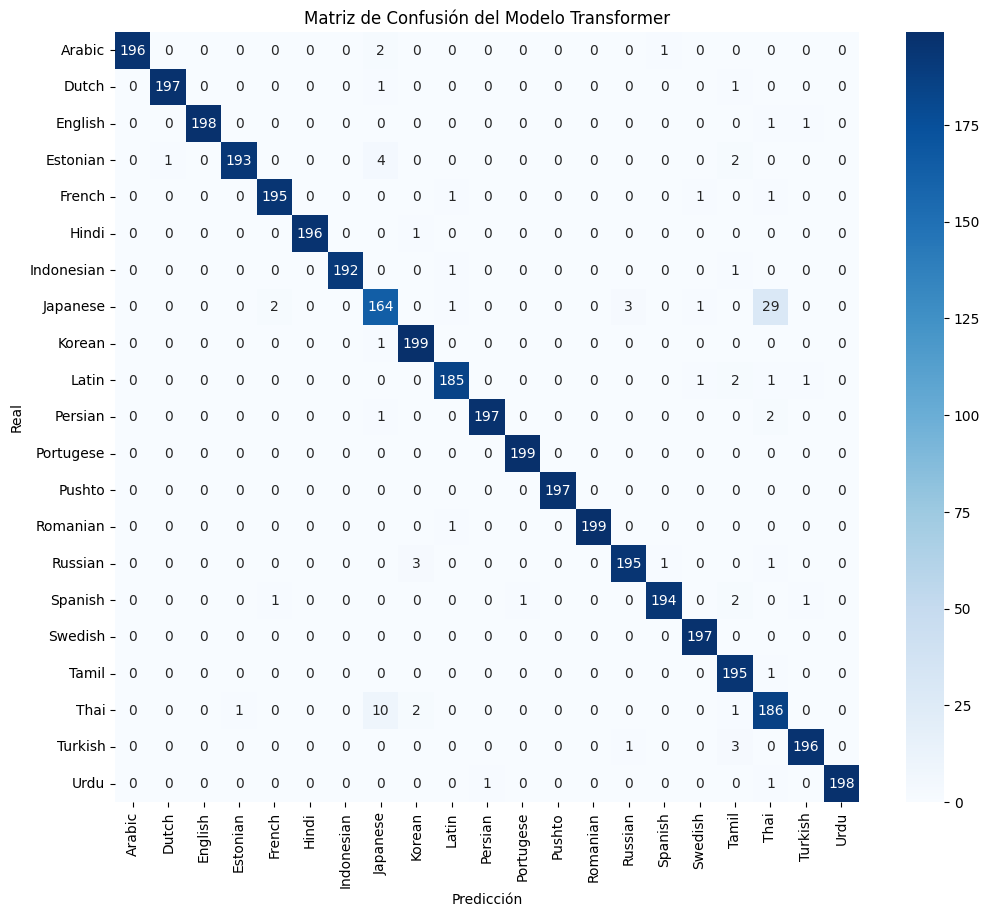

<Figure size 640x480 with 0 Axes>

In [144]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=language_names, yticklabels=language_names)
plt.title("Matriz de Confusión del Modelo Transformer")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()
plt.savefig("plots/transformer_confusion_matrix.png")

### Matriz de Confusión Normalizada

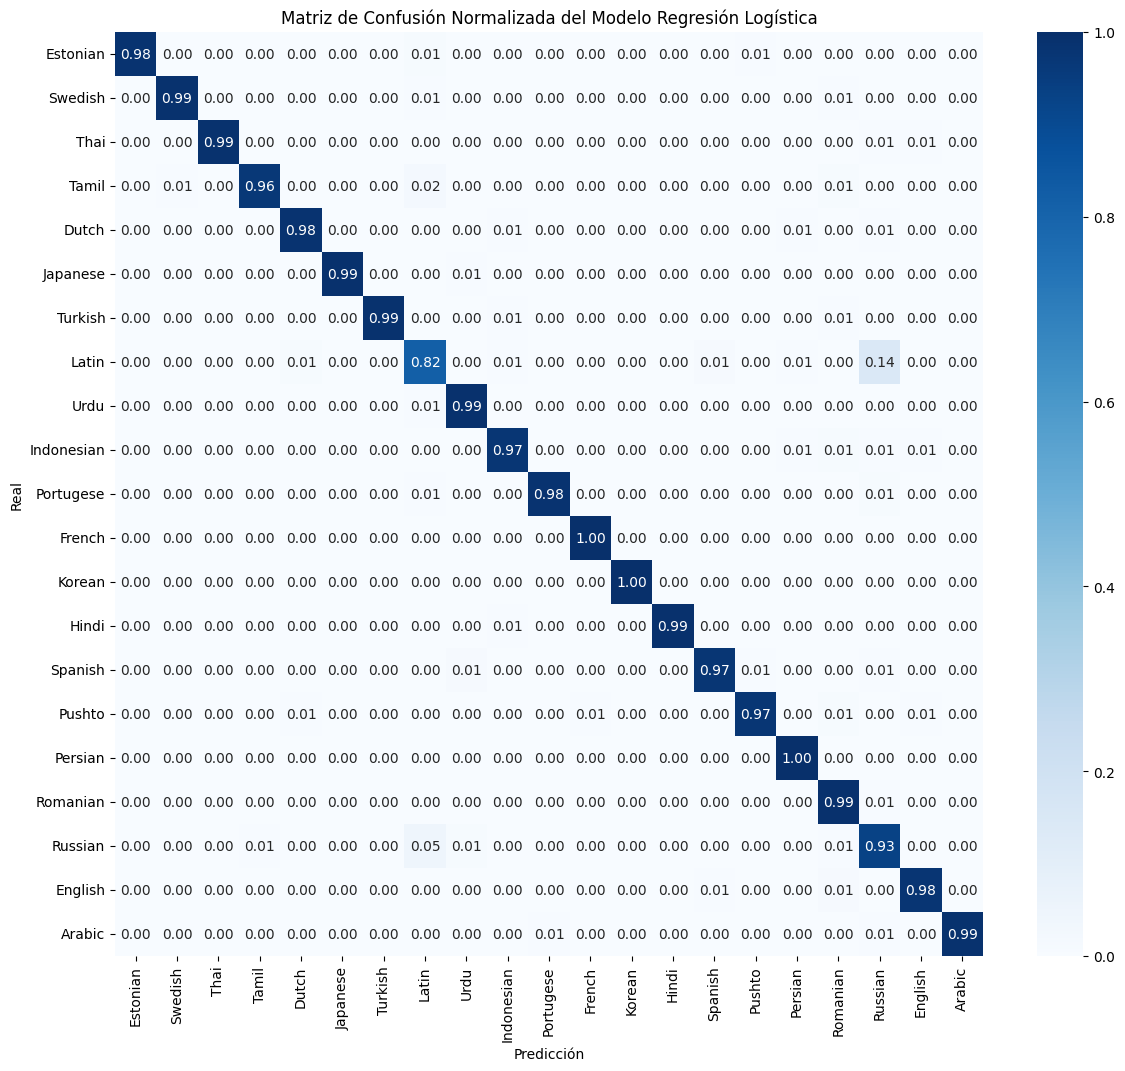

<Figure size 640x480 with 0 Axes>

In [154]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=df['Language'].unique(), yticklabels=df['Language'].unique())
plt.title("Matriz de Confusión Normalizada del Modelo Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()
plt.savefig("plots/transformer_confusion_matrix_normalized.png")

### Accuracy en Train y Test

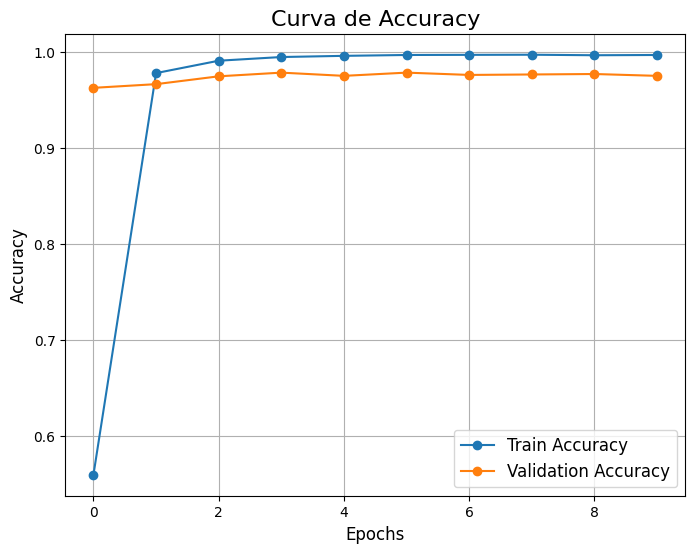

<Figure size 640x480 with 0 Axes>

In [147]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Train Accuracy', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Curva de Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
plt.savefig("plots/transformer_accuracy_curve.png")

### Loss en Train y Test

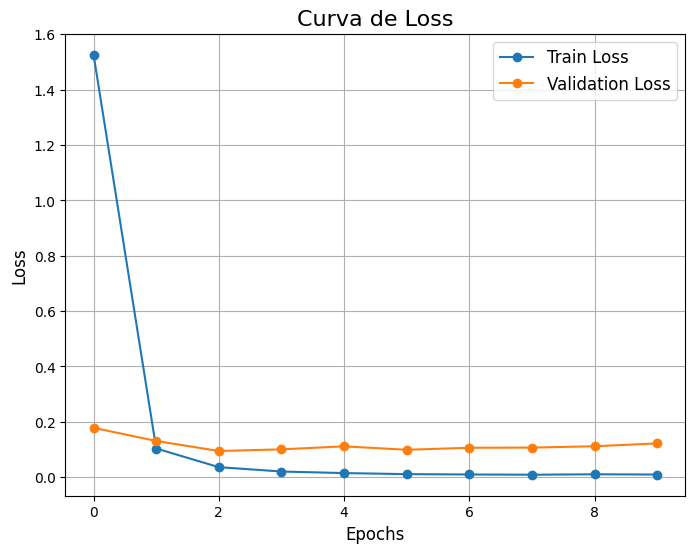

<Figure size 640x480 with 0 Axes>

In [148]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Curva de Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
plt.savefig("plots/transformer_loss_curve.png")